# Project: NLP / Spam Link Detection System


# Step 1: Import Essential Libraries 

In [28]:
# Libraries specialized "expert kits" to plug into Python essential for EDA.
import joblib
import requests
import os
import json
import pickle # -- Binary (unreadable by humans) -- Can save almost any Python object -- Very fast for complex objects --
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from numpy._core.defchararray import upper
from pathlib import Path
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest, f_regression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Step 2: Problem Statement / Data Collection
## 2.1 Description of the Problem
- We want to implement a system that is able to automatically detect whether a web page contains spam or not based on its URL.

## 2.2 Inicitial Loading and Inspection

In [2]:
def setup_project_structure(base_path, subfolders):
    """Creates a standard data science directory tree."""
    for folder in subfolders:
        folder_path = Path(base_path) / folder
        folder_path.mkdir(parents=True, exist_ok=True)
    print(f"Project structure initialized in: {base_path}")

def download_dataset_to_raw(url, full_path):
    """Downloads a file to a specific path."""
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(full_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
            
        print(f"Download successful! Saved to: {full_path}")
        return True
    except Exception as e:
        print(f"Download failed: {e}")
        return False

    except requests.exceptions.RequestException as e:
        print(f"An error occurred during the download: {e}")
        return False
    
# --- CONFIGURATION ---
BASE_DIR = "../data"
FOLDERS = ["raw", "processed", "interim"]
DATA_URL = "https://breathecode.herokuapp.com/asset/internal-link?id=435&path=url_spam.csv"
TARGET_FILE = "url_spam.csv"

# EXECUTION
# Build the whole house
setup_project_structure(BASE_DIR, FOLDERS)

# Put the data in the 'raw' room
RAW_FILE_PATH = Path(BASE_DIR) / "raw" / TARGET_FILE
download_dataset_to_raw(DATA_URL, RAW_FILE_PATH)

Project structure initialized in: ../data
Download successful! Saved to: ../data/raw/url_spam.csv


True

In [3]:
# Define the full path again for reading
try:
    df = pd.read_csv(RAW_FILE_PATH, sep= None, engine= 'python')
    print("\nDataset loaded successfully into a DataFrame:")
except FileNotFoundError:
    print(f"\nError: File not found at {RAW_FILE_PATH}")


Dataset loaded successfully into a DataFrame:


# Step 3: Exploration and Data Cleaning

## 3.1 DataSet Dimension & Tipology Visibility

In [4]:
row, col = df.shape
print(f"The Dataset has {row} number of rows and {col} columns.")

The Dataset has 2999 number of rows and 2 columns.


## 3.2 Top 5 Row View

In [5]:
top_five_data = df.head()
print("These are the DataSet top 5 columns view to be analized:")
print(tabulate(top_five_data, headers='keys', tablefmt='psql'))

These are the DataSet top 5 columns view to be analized:
+----+-----------------------------------------------------+-----------+
|    | url                                                 | is_spam   |
|----+-----------------------------------------------------+-----------|
|  0 | https://briefingday.us8.list-manage.com/unsubscribe | True      |
|  1 | https://www.hvper.com/                              | True      |
|  2 | https://briefingday.com/m/v4n3i4f3                  | True      |
|  3 | https://briefingday.com/n/20200618/m#commentform    | False     |
|  4 | https://briefingday.com/fan                         | True      |
+----+-----------------------------------------------------+-----------+


## 3.3 Data Types and Non-Nulls Values Overview.

In [6]:
print("This is the information about Non-Null and Dtype:\n================================================")
print(df.info())

This is the information about Non-Null and Dtype:
<class 'pandas.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   url      2999 non-null   str  
 1   is_spam  2999 non-null   bool 
dtypes: bool(1), str(1)
memory usage: 26.5 KB
None


## 3.4 Check Unique

In [7]:
print("These are the Unique Values for each columns on the Dataset:\n============================================================")
print(df.nunique())

These are the Unique Values for each columns on the Dataset:
url        2369
is_spam       2
dtype: int64


## 3.5 Check for Duplicates Values

In [8]:
# Since there are no identifiers, duplicate check looked at the entire row.
duplicate_val = df.duplicated().sum()
print(f"<< {duplicate_val} >> duplicated value in the dataset.")

<< 630 >> duplicated value in the dataset.


## 3.6 Duplicates Inspection

In [9]:
# Finding duplicates is a vital cleaning step.
duplicate_rows = df[df.duplicated(keep= False)]
print("Table with duplicates rows (in case they are and only for visibility):\n======================================================")
print(tabulate(duplicate_rows.head(24), headers= "keys", tablefmt= "psql"))

Table with duplicates rows (in case they are and only for visibility):
+-----+------------------------------------------------------------------------------------------------------+-----------+
|     | url                                                                                                  | is_spam   |
|-----+------------------------------------------------------------------------------------------------------+-----------|
|   0 | https://briefingday.us8.list-manage.com/unsubscribe                                                  | True      |
|   1 | https://www.hvper.com/                                                                               | True      |
|   2 | https://briefingday.com/m/v4n3i4f3                                                                   | True      |
|   4 | https://briefingday.com/fan                                                                          | True      |
|  22 | https://www.technologyreview.com/innovators-under-35/2020/  

## 3.7 Drop Duplicates

In [10]:
# 1. Count original rows
original_count = len(df)

# 2. Remove duplicates, keeping only the first occurrence
df = df.drop_duplicates(subset=['url'], keep='first')

# 3. Calculate how many were removed
new_count = len(df)
print(f"Removed {original_count - new_count} duplicate URLs.")
print(f"Unique URLs remaining: {new_count}")

Removed 630 duplicate URLs.
Unique URLs remaining: 2369


## 3.8 Categorical to Numerical Transformation

In [13]:
# No need to use the Apply lambda function to convert as boolean True is 1 and False to 0
# Shorter way to achieve the same result:
df['is_spam'] = df['is_spam'].astype(int)
print(tabulate(df.head(), headers= "keys", tablefmt= "psql"))

+----+-----------------------------------------------------+-----------+
|    | url                                                 |   is_spam |
|----+-----------------------------------------------------+-----------|
|  0 | https://briefingday.us8.list-manage.com/unsubscribe |         1 |
|  1 | https://www.hvper.com/                              |         1 |
|  2 | https://briefingday.com/m/v4n3i4f3                  |         1 |
|  3 | https://briefingday.com/n/20200618/m#commentform    |         0 |
|  4 | https://briefingday.com/fan                         |         1 |
+----+-----------------------------------------------------+-----------+


## 3.9 Count Class Cases

In [ ]:
print(len(df))
print(f"Spam: {len(df.loc[df.is_spam == 1])}")
print(f"No Spam: {len(df.loc[df.is_spam == 0])}")

2369
Spam: 244
No Spam: 2125


### 3.9.1 Conclusion Class Cases
- The dataset is roughly 90% "No Spam" and only 10% "Spam".
- The model could predict 90% only No Spam. Let's see!

# Step 4. Text Processing

## 4.1 The URL Tokenizer Function

In [20]:
def preprocess_url(url):
    # 1. Remove the protocol (http, https) and 'www' 
    # These are in almost every URL and don't help distinguish spam
    url = re.sub(r'(https?://)|(www\.)', '', url)
    
    # 2. Replace punctuation (/, ., -, _, ?, =, &) with spaces
    url = re.sub(r'[./\-_?=&]', ' ', url)
    
    # 3. Lowercase everything and split into a list of words
    return url.lower().split()

# Apply it to the unique URLs
df['tokens'] = df['url'].apply(preprocess_url)

In [26]:
print(tabulate(df.head(), headers= "keys", tablefmt= "psql"))

+----+-----------------------------------------------------+-----------+----------------------------------------------------------------+---------------------------------------------+
|    | url                                                 |   is_spam | tokens                                                         | cleaned_url                                 |
|----+-----------------------------------------------------+-----------+----------------------------------------------------------------+---------------------------------------------|
|  0 | https://briefingday.us8.list-manage.com/unsubscribe |         1 | ['briefingday', 'us8', 'list', 'manage', 'com', 'unsubscribe'] | briefingday us8 list manage com unsubscribe |
|  1 | https://www.hvper.com/                              |         1 | ['hvper', 'com']                                               | hvper com                                   |
|  2 | https://briefingday.com/m/v4n3i4f3                  |         1 | ['brief

## 4.2 Lemmatization Process

In [24]:
# 1. Download the 'dictionary' and the 'boring words' list
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_tokens(tokens):
    # 2. Extract the root of each word (Lemmatize)
    # 3. Remove stopwords (the, is, at, etc.)
    # 4. Remove very short noise (length <= 2)
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    
    # 5. Join them back into a string for the Vectorizer
    return " ".join(cleaned)

# Create the final cleaned text column
df['cleaned_url'] = df['tokens'].apply(clean_tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...


In [27]:
print(tabulate(df.head(), headers= "keys", tablefmt= "psql"))

+----+-----------------------------------------------------+-----------+----------------------------------------------------------------+---------------------------------------------+
|    | url                                                 |   is_spam | tokens                                                         | cleaned_url                                 |
|----+-----------------------------------------------------+-----------+----------------------------------------------------------------+---------------------------------------------|
|  0 | https://briefingday.us8.list-manage.com/unsubscribe |         1 | ['briefingday', 'us8', 'list', 'manage', 'com', 'unsubscribe'] | briefingday us8 list manage com unsubscribe |
|  1 | https://www.hvper.com/                              |         1 | ['hvper', 'com']                                               | hvper com                                   |
|  2 | https://briefingday.com/m/v4n3i4f3                  |         1 | ['brief

## 4.3 Word Cloud for Visual

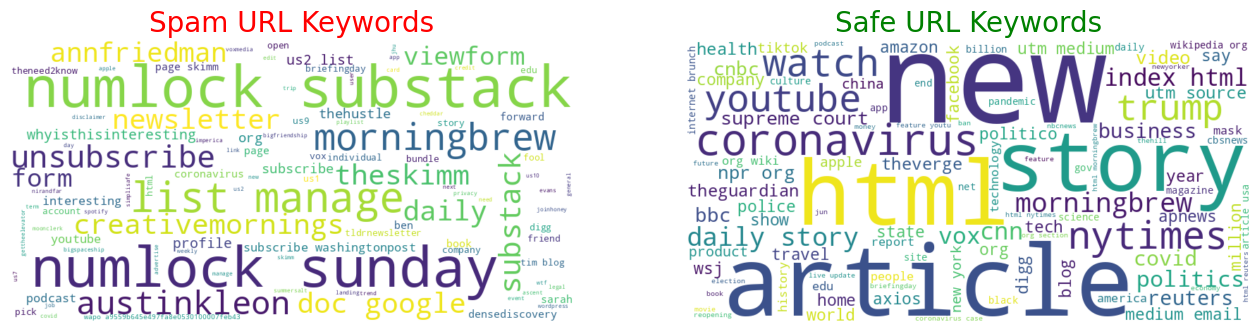

In [32]:
# I will only visualize the top 100 words
# 1. Separate the text by category
spam_text = " ".join(df[df['is_spam'] == 1]['cleaned_url'])
no_spam_text = " ".join(df[df['is_spam'] == 0]['cleaned_url'])

# 2. Configure the WordCloud appearance
wc = WordCloud(width= 800, height= 400, background_color= 'white', max_words= 100)

# 3. Create the visualization
plt.figure(figsize=(16, 8))

# Subplot 1: Spam
plt.subplot(1, 2, 1)
spam_cloud = wc.generate(spam_text)
plt.imshow(spam_cloud, interpolation= 'bilinear')
plt.title('Spam URL Keywords', fontsize= 20, color= 'red')
plt.axis('off')

# Subplot 2: Non-Spam (Ham)
plt.subplot(1, 2, 2)
no_spam_cloud = wc.generate(no_spam_text)
plt.imshow(no_spam_cloud, interpolation= 'bilinear')
plt.title('Safe URL Keywords', fontsize= 20, color= 'green')
plt.axis('off')

plt.show()

### 4.3.1 Conclusion Word Cloud Visual